# Basic

In [29]:
from typing_extensions import TypedDict

# Define your state structure
class State(TypedDict):
    graph_state: str

# Define your nodes
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] + " I am"}
def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] + " happy!"}
def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] + " sad!"}

# Define your conditional function
import random
from typing import Literal
def decide_mood(state) -> Literal["node_2", "node_3"]:    
    # Choose randomly between happy and sad
    if random.random() < 0.5:
        return "node_2"
    return "node_3"

# Build your graph
from langgraph.graph import StateGraph, START, END
def build_graph():
    builder = StateGraph(State)
    # Add your nodes
    builder.add_node("node_1", node_1)
    builder.add_node("node_2", node_2)
    builder.add_node("node_3", node_3)
    # Connect them with edges
    builder.add_edge(START, "node_1")
    builder.add_conditional_edges("node_1", decide_mood, ["node_2", "node_3"])
    builder.add_edge("node_2", END)
    builder.add_edge("node_3", END)
    # Compile your graph
    graph = builder.compile()
    return graph
graph = build_graph()

# Execute your graph
result = graph.invoke({"graph_state": "Hi, this is kumar."})
result

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is kumar. I am sad!'}

# 병렬 Subgraph 예시

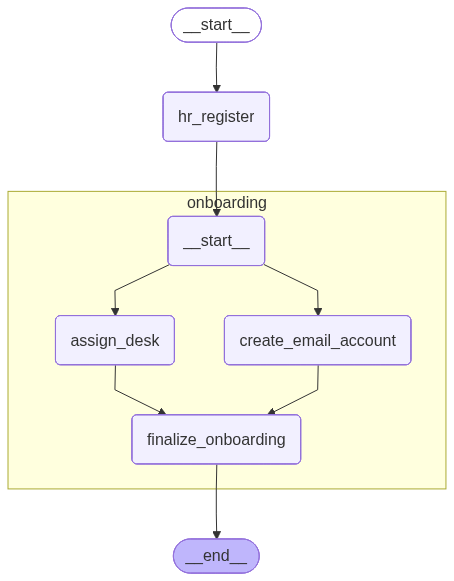

[HR] 신입 등록 시작 - Bob
>>> HRState: {'employee_name': 'Bob'}
>>>>> CHUNK: {'hr_register': {'employee_name': 'Bob'}}
---assign_desk---
>>> OnboardingState: {'employee_name': 'Bob'}
---create_email_account---
>>> OnboardingState: {'employee_name': 'Bob'}
---finalize_onboarding---
>>> OnboardingState: {'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}
>>>>> CHUNK: {'onboarding': {'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}}


In [62]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# ---------------------------
# Subgraph: 온보딩 병렬 프로세스
# ---------------------------
class OnboardingState(TypedDict):
    employee_name: str
    email: str
    desk: str

def create_email_account(state: OnboardingState):
    print("---create_email_account---")
    print(f">>> OnboardingState: {state}")
    return {"email": f"{state['employee_name'].lower()}@company.com"}

def assign_desk(state: OnboardingState):
    print("---assign_desk---")
    print(f">>> OnboardingState: {state}")
    return {"desk": f"Desk-{state['employee_name'][0].upper()}01"}

def finalize_onboarding(state: OnboardingState):
    print("---finalize_onboarding---")
    print(f">>> OnboardingState: {state}")
    return {
        "employee_name": state["employee_name"],
        "email": state["email"],
        "desk": state["desk"]
    }

onboarding_builder = StateGraph(OnboardingState)
onboarding_builder.add_node(create_email_account)
onboarding_builder.add_node(assign_desk)
onboarding_builder.add_node(finalize_onboarding)

# 병렬 실행: START에서 두 개 분기
onboarding_builder.add_edge(START, "create_email_account")
onboarding_builder.add_edge(START, "assign_desk")

# 두 결과가 모여서 finalize로 들어감
onboarding_builder.add_edge("create_email_account", "finalize_onboarding")
onboarding_builder.add_edge("assign_desk", "finalize_onboarding")

onboarding_process = onboarding_builder.compile()

# ---------------------------
# Parent graph: 인사팀 처리
# ---------------------------
class HRState(TypedDict):
    employee_name: str
    email: str
    desk: str

def hr_register(state: HRState):
    print(f"[HR] 신입 등록 시작 - {state['employee_name']}")
    print(f">>> HRState: {state}")
    return {"employee_name": state["employee_name"]}

builder = StateGraph(HRState)
builder.add_node("hr_register", hr_register)
builder.add_node("onboarding", onboarding_process)

builder.add_edge(START, "hr_register")
builder.add_edge("hr_register", "onboarding")

graph = builder.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

# ---------------------------
# 실행 예시
# ---------------------------
for chunk in graph.stream({"employee_name": "Bob"}):
    print(f">>>>> CHUNK: {chunk}")


#### 핵심노트 : 시작할 때, state["employee_name"]는 HRState에 기록되는데, 서브 그래프 onboarding_process에서 어떻게 HRState의 state["employee_name"]를 가져올 수 있나요?

좋은 질문이에요 👏 핵심은 부모 그래프(Parent Graph)의 상태가 서브 그래프(Subgraph)로 공유된다는 점입니다. <br>
LangGraph의 StateGraph는 TypedDict 기반으로 "상태(State)"를 정의하고, 상위 그래프에서 가지고 있는 키가 하위 서브 그래프의 상태에도 자동으로 주입됩니다.

##### 지금 구조에서 흐름 설명

1. ParentState (HRState) 정의:<br>
    ```python
    class HRState(TypedDict):
        employee_name: str
        email: str
        desk: str
    ```

2. SubgraphState (OnboardingState) 정의: <br>
    ```python
    class OnboardingState(TypedDict):
        employee_name: str   # 부모의 키와 동일
        email: str
        desk: str
    ```

3. 실행할 때 graph.stream({"employee_name": "Bob"}) → Parent Graph 시작 → HR Node 실행 → 그 결과로 {"employee_name": "Bob"} 상태 유지 <br>

4. Subgraph 실행 시 → 부모 상태의 "employee_name"이 서브그래프 초기 상태에 그대로 전달됨 <br>
   그래서 create_email_account(state: OnboardingState) 안에서
   ```python
    state["employee_name"]
   ```
   을 그대로 가용 가능

##### 동작원리 (정리)
- 공유되는 키: 부모 상태와 자식(서브 그래프) 상태에서 키 이름이 같으면 자동 매핑
- 부모 → 자식: 부모에서 이미 가지고 있는 값이 서브그래프 시작 시 초기값으로 복사됨
- 자식 → 부모: 서브그래프 안에서 업데이트된 값은 실행이 끝나면 부모 상태에도 반영됨

##### 그림으로 비유
- 부모 상태(HRState): 큰 화이트보드
- 서브 그래프(OnboardingState): 작은 화이트보드<br>
  -- 부모 보드에서 "employee_name": "Bob" 이 이미 적혀있음<br>
  -- 작은 화이트보드를 시작할 때 이 값이 그대로 복사되어 있음<br>
- 서브그래프 안에서는 "employee_name"을 자유롭게 읽어서 쓰고, 새로운 "email", "desk" 같은 값은 서브 그래프 종료 후 부모 보드에도 합쳐짐



# Parent graph와 Subgraph 간의 State 키가 다른 경우 (별도 맵핑 프로세스 필요)

In [71]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START

# -----------------------------
# Subgraph (온보딩 프로세스)
# -----------------------------
class OnboardingState(TypedDict):
    username: str

def create_account(state: OnboardingState):
    return {"username": f"{state['username']} (계정 생성 완료)"}

def provide_equipment(state: OnboardingState):
    return {"username": f"{state['username']} → 노트북 지급 완료"}

onboarding_builder = StateGraph(OnboardingState)
onboarding_builder.add_node("create_account", create_account)
onboarding_builder.add_node("provide_equipment", provide_equipment)
onboarding_builder.add_edge(START, "create_account")
onboarding_builder.add_edge("create_account", "provide_equipment")
onboarding = onboarding_builder.compile()

# -----------------------------
# Parent Graph (HR 프로세스)
# -----------------------------
class HRState(TypedDict):
    employee_id: str
    name: str

def call_onboarding(state: HRState):
    # (1) Parent → Subgraph로 매핑 (name → username)
    onboarding_output = onboarding.invoke({"username": state["name"]})
    print(f">>> SubGraph Onboarding Output: {onboarding_output}")
    
    # (2) Subgraph 결과를 Parent에 다시 매핑
    return {
        "employee_id": state["employee_id"],
        "name": onboarding_output["username"] + " → 온보딩 완료!"
    }

hr_builder = StateGraph(HRState)
hr_builder.add_node("onboarding_process", call_onboarding)
hr_builder.add_edge(START, "onboarding_process")
hr_graph = hr_builder.compile()

result = hr_graph.invoke({"employee_id": "E001", "name": "홍길동"})
print(result)

>>> SubGraph Onboarding Output: {'username': '홍길동 (계정 생성 완료) → 노트북 지급 완료'}
{'employee_id': 'E001', 'name': '홍길동 (계정 생성 완료) → 노트북 지급 완료 → 온보딩 완료!'}


# Add persistence

In [100]:
from typing_extensions import TypedDict
from langgraph.graph.state import StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

# ---------------------------
# 유틸: 공통 로그 출력
# ---------------------------
def debug_log(step: str, state: dict):
    print(f"--- {step} ---")
    print(f">>> State: {state}")


# ---------------------------
# State 정의
# ---------------------------
class EmployeeBase(TypedDict):
    employee_name: str

class OnboardingState(EmployeeBase):
    email: str
    desk: str

class HRState(EmployeeBase):
    email: str
    desk: str


# ---------------------------
# Subgraph: 온보딩 병렬 프로세스
# ---------------------------
def onboarding_create_email(state: OnboardingState):
    debug_log("onboarding_create_email", state)
    return {"email": f"{state['employee_name'].lower()}@company.com"}

def onboarding_assign_desk(state: OnboardingState):
    debug_log("onboarding_assign_desk", state)
    return {"desk": f"Desk-{state['employee_name'][0].upper()}01"}

def onboarding_finalize(state: OnboardingState):
    debug_log("onboarding_finalize", state)
    return {
        "employee_name": state["employee_name"],
        "email": state["email"],
        "desk": state["desk"]
    }

def build_onboarding_graph():
    builder = StateGraph(OnboardingState)
    builder.add_node(onboarding_create_email)
    builder.add_node(onboarding_assign_desk)
    builder.add_node(onboarding_finalize)

    # 병렬 시작
    builder.add_edge(START, "onboarding_create_email")
    builder.add_edge(START, "onboarding_assign_desk")

    # 결과 모아 finalize
    builder.add_edge("onboarding_create_email", "onboarding_finalize")
    builder.add_edge("onboarding_assign_desk", "onboarding_finalize")

    return builder.compile(checkpointer=True)


# ---------------------------
# Parent graph: 인사팀 처리
# ---------------------------
def hr_register(state: HRState):
    debug_log("hr_register", state)
    print(f"[HR] 신입 등록 시작 - {state['employee_name']}")
    return {"employee_name": state["employee_name"]}

def build_hr_graph():
    builder = StateGraph(HRState)
    builder.add_node("hr_register", hr_register)
    builder.add_node("onboarding", build_onboarding_graph())

    builder.add_edge(START, "hr_register")
    builder.add_edge("hr_register", "onboarding")
    memory_saver = MemorySaver()

    return builder.compile(checkpointer=memory_saver)


# ---------------------------
# 실행 예시
# ---------------------------
if __name__ == "__main__":
    graph = build_hr_graph()
    for chunk in graph.stream({"employee_name": "Bob"}, config={"configurable": {"thread_id": "onboarding-thread-1"}}):
        print(f">>>>> CHUNK: {chunk}")


--- hr_register ---
>>> State: {'employee_name': 'Bob'}
[HR] 신입 등록 시작 - Bob
>>>>> CHUNK: {'hr_register': {'employee_name': 'Bob'}}
--- onboarding_assign_desk ---
>>> State: {'employee_name': 'Bob'}
--- onboarding_create_email ---
>>> State: {'employee_name': 'Bob'}
--- onboarding_finalize ---
>>> State: {'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}
>>>>> CHUNK: {'onboarding': {'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}}


In [103]:
# 최종 State 상태 조회
graph.get_state(config={"configurable": {"thread_id": "onboarding-thread-1"}})

StateSnapshot(values={'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}, next=(), config={'configurable': {'thread_id': 'onboarding-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f09c62c-824e-6b50-8002-c60bad11bc4a'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-28T12:00:52.707617+00:00', parent_config={'configurable': {'thread_id': 'onboarding-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f09c62c-823e-62e8-8001-9c4a336c6ec4'}}, tasks=(), interrupts=())

In [102]:
history = list(graph.get_state_history(config={"configurable": {"thread_id": "onboarding-thread-1"}}))
history

[StateSnapshot(values={'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}, next=(), config={'configurable': {'thread_id': 'onboarding-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f09c62c-824e-6b50-8002-c60bad11bc4a'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-28T12:00:52.707617+00:00', parent_config={'configurable': {'thread_id': 'onboarding-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f09c62c-823e-62e8-8001-9c4a336c6ec4'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'employee_name': 'Bob'}, next=('onboarding',), config={'configurable': {'thread_id': 'onboarding-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f09c62c-823e-62e8-8001-9c4a336c6ec4'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-28T12:00:52.700848+00:00', parent_config={'configurable': {'thread_id': 'onboarding-thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f09c62c-823a-6cd7-8000-c5f78caf03fb'}}, tasks=(PregelTask

#### History 읽는 방법

1. 초기 입력 단계 (step = -1)
    ```python
    StateSnapshot(
        values={}, 
        next=('__start__',), 
        metadata={'source': 'input', 'step': -1}, 
        tasks=(..., result={'employee_name': 'Bob'})
        )
    # - source = input → 외부에서 들어온 입력 단계.
    # - values = {} (아직 state 값 없음).
    # - next = ('start',) → 이 다음에 __start__ 노드 실행 예정.
    # - tasks 안에 result={'employee_name': 'Bob'} → 사용자 입력에서 "Bob" 이라는 이름이 들어옴.
    ```


2. HR 등록 단계 (step = 0)
    ```python
    StateSnapshot(
        values={'employee_name': 'Bob'}, 
        next=('hr_register',), 
        metadata={'source': 'loop', 'step': 0}, 
        tasks=(..., name='hr_register', result={'employee_name': 'Bob'})
        )
    # - values = {'employee_name': 'Bob'} → 이제 state에 직원 이름 저장됨.
    # - next=('hr_register',) → 다음 실행은 hr_register 노드.
    # - task = hr_register 실행 결과도 "Bob"만 포함됨.
    ```

3. 온보딩 단계 (step = 1)
    ```python
    StateSnapshot(
        values={'employee_name': 'Bob'}, 
        next=('onboarding',), 
        metadata={'step': 1}, 
        tasks=(..., name='onboarding', result={'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'})
        )
    # - 여전히 values에는 employee_name만 있음 → 아직 merge 안 된 상태.
    # - Task = onboarding 실행 결과에서 추가 정보(email, desk) 생성됨.
    ```

4. 최종 병합 단계 (step = 2)
    ```python
    StateSnapshot(
        values={'employee_name': 'Bob', 'email': 'bob@company.com', 'desk': 'Desk-B01'}, 
        next=(), 
        metadata={'step': 2}
        )
    # - 이제 values가 최종 병합되어 이름 + 이메일 + 책상 정보 모두 포함.
    # - next=() → 다음에 실행할 노드 없음 → 워크플로우 종료. 
    ```